In [59]:
import os
import yaml
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import random

# Import required components from your project
from data_loader import load_and_segment_data, SensorDataset, train_val_test_split
from models.cnn_model import CNNModel
from models.lstm import LSTMModel

# -------------------------------
# CONFIGURATION & DATA LOADING
# -------------------------------
# Load configuration from YAML file
config_path = os.path.join("config", "lstm.yaml")
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

# Load data (using training set for visualization; adjust data_dir as needed)
X, y, labels = load_and_segment_data(
    data_dir="dataset/train",
    window_size=config['window_size'],
    predict_size=config['predict_size'],
    balance_config=config
)

# Split data into train, validation, and test sets
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X, y, labels, test_size=0.2, val_size=0.4, random_state=42
)
# X_train, X_val, X_test, y_train, y_val, y_test, labels_train, labels_val, labels_test = train_val_test_split(
#     X, y, labels, test_size=0.2, val_size=0.4, random_state=42
# )

# Create the training dataset (normalization is applied in SensorDataset)
train_dataset = SensorDataset(X_train, y_train, normalize=True)
#train_dataset = SensorDataset(X_train, y_train, labels=X_train_labels, normalize=True)

# -------------------------------
# MODEL LOADING
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if config["model_type"] == "cnn":
    model = CNNModel(window_size=config['window_size'],
                 predict_size=config['predict_size'],
                 num_features=6)
elif config["model_type"] == "lstm":
        model = LSTMModel(input_size=6,hidden_size=config.get('hidden_size', 64), num_layers=config.get('num_layers', 2),predict_size=config['predict_size'])
model_path = config.get('model_save_path', "./output_model/lstm.pth")
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()



/var/folders/1b/x02b24d16rbf3gjfvngp6hqw0000gn/T/ipykernel_89560/1585923021.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

LSTMModel(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=60, bias=True)
)

In [60]:
# -------------------------------
# DEFINE VISUALIZATION FUNCTION
# -------------------------------
def visualize_sample(sample, model, config, device):
    """
    Given a sample (tuple of (input, ground truth)) from the dataset,
    this function predicts the output using the model and plots:
      - Input sequence for each sensor channel.
      - Ground truth sequence (solid line) for each sensor channel.
      - Predicted sequence (dotted line) for each sensor channel.
    The plots are created in two figures (sensors 1-3 and sensors 4-6).
    """
    # Unpack sample: sample_X shape: (window_size, 6), sample_y shape: (predict_size, 6)
    sample_X, sample_y = sample
    sample_X = sample_X.unsqueeze(0)  # add batch dimension

    # Model prediction
    with torch.no_grad():
        pred_y = model(sample_X)  # shape: (1, predict_size, 6)
    
    # Remove batch dimension and convert to numpy arrays
    sample_X = sample_X.cpu().numpy().squeeze()    # (window_size, 6)
    sample_y = sample_y.cpu().numpy().squeeze()      # (predict_size, 6)
    pred_y   = pred_y.cpu().numpy().squeeze()        # (predict_size, 6)
    
    window_size = config['window_size']
    predict_size = config['predict_size']
    time_axis_input = np.arange(window_size)
    time_axis_pred  = np.arange(window_size, window_size + predict_size)
    
    # Plot sensors 1-3 in one figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
    axes = [ax1, ax2, ax3]
    for idx, ax in enumerate(axes):
        ch = idx  # sensor channels 0,1,2
        ax.plot(time_axis_input, sample_X[:, ch], color=f'C{ch}', label="Input", linewidth=2)
        ax.plot(time_axis_pred, sample_y[:, ch], color=f'C{ch}', linestyle='-', marker='o', markersize=4, label="Ground Truth")
        ax.plot(time_axis_pred, pred_y[:, ch], color=f'C{ch}', linestyle=':', marker='x', markersize=4, label="Prediction")
        ax.set_title(f"Sensor {ch+1}")
        ax.set_xlabel("Time Step")
        ax.grid(True)
        if idx == 0:
            ax.set_ylabel("Normalized Value")
        ax.legend()
    fig.suptitle("Sensors 1-3: Input, Ground Truth, and Prediction")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    # Plot sensors 4-6 in a second figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
    axes = [ax1, ax2, ax3]
    for idx, ax in enumerate(axes):
        ch = idx + 3  # sensor channels 3,4,5
        ax.plot(time_axis_input, sample_X[:, ch], color=f'C{ch}', label="Input", linewidth=2)
        ax.plot(time_axis_pred, sample_y[:, ch], color=f'C{ch}', linestyle='-', marker='o', markersize=4, label="Ground Truth")
        ax.plot(time_axis_pred, pred_y[:, ch], color=f'C{ch}', linestyle=':', marker='x', markersize=4, label="Prediction")
        ax.set_title(f"Sensor {ch+1}")
        ax.set_xlabel("Time Step")
        ax.grid(True)
        if idx == 0:
            ax.set_ylabel("Normalized Value")
        ax.legend()
    fig.suptitle("Sensors 4-6: Input, Ground Truth, and Prediction")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Visualizing sample index: 25


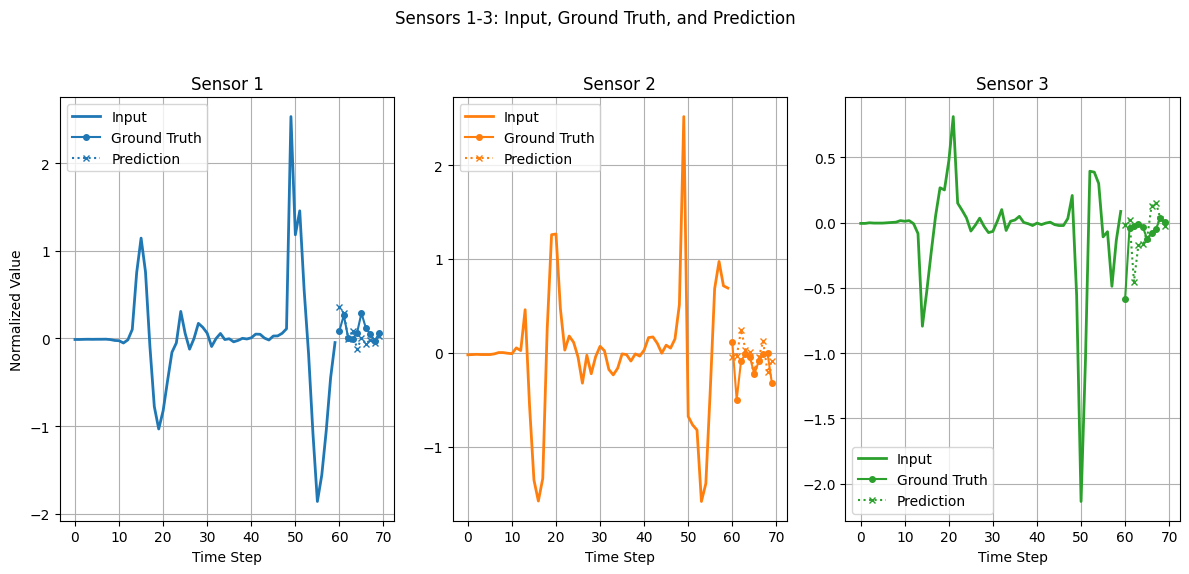

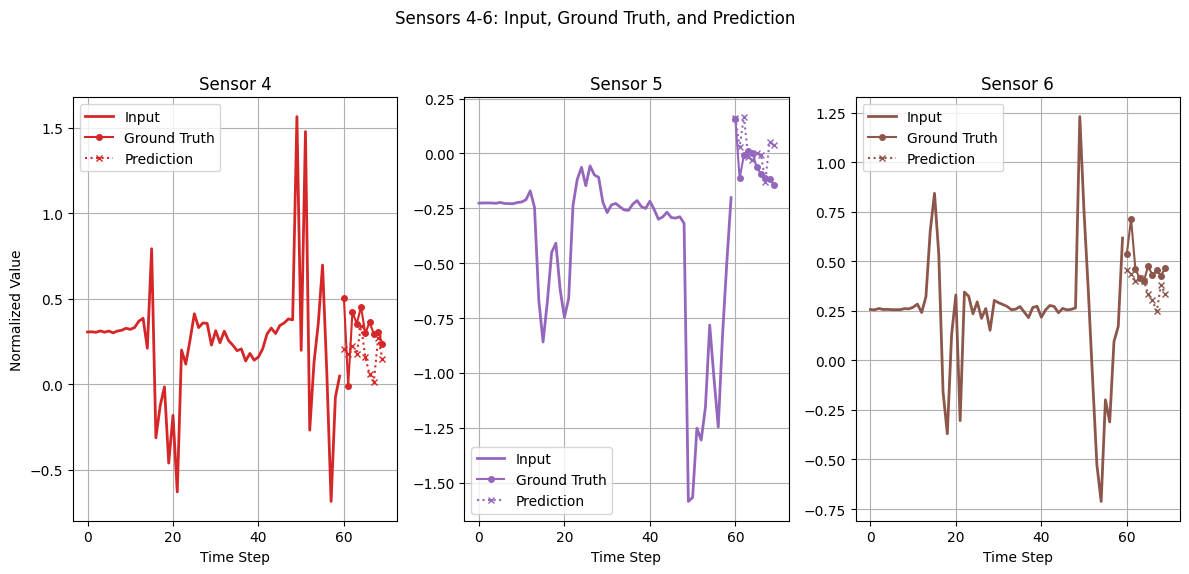

Visualizing sample index: 30


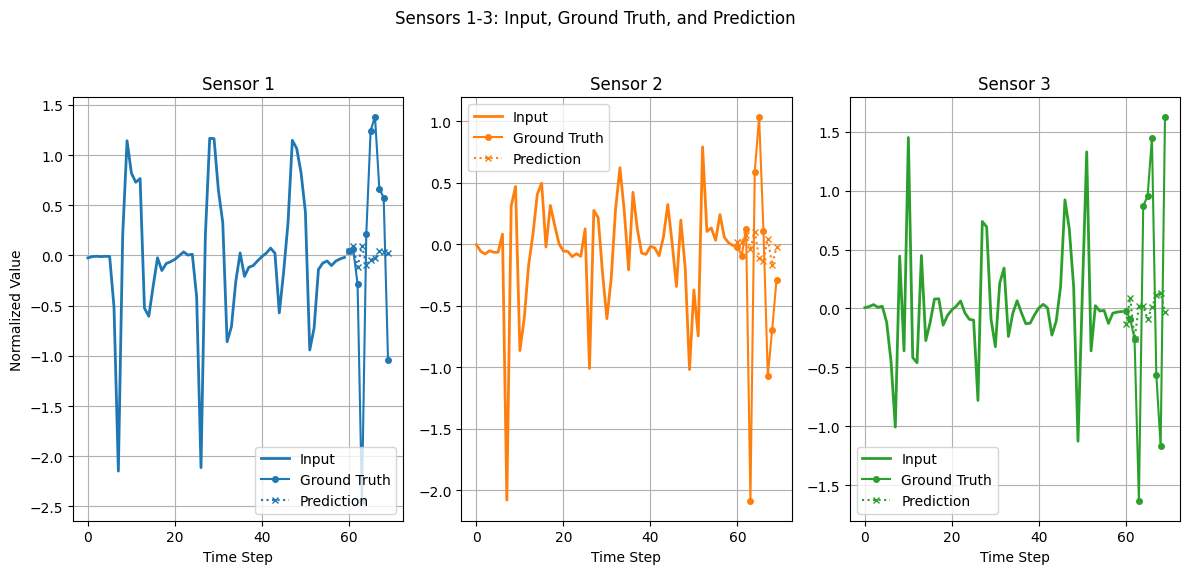

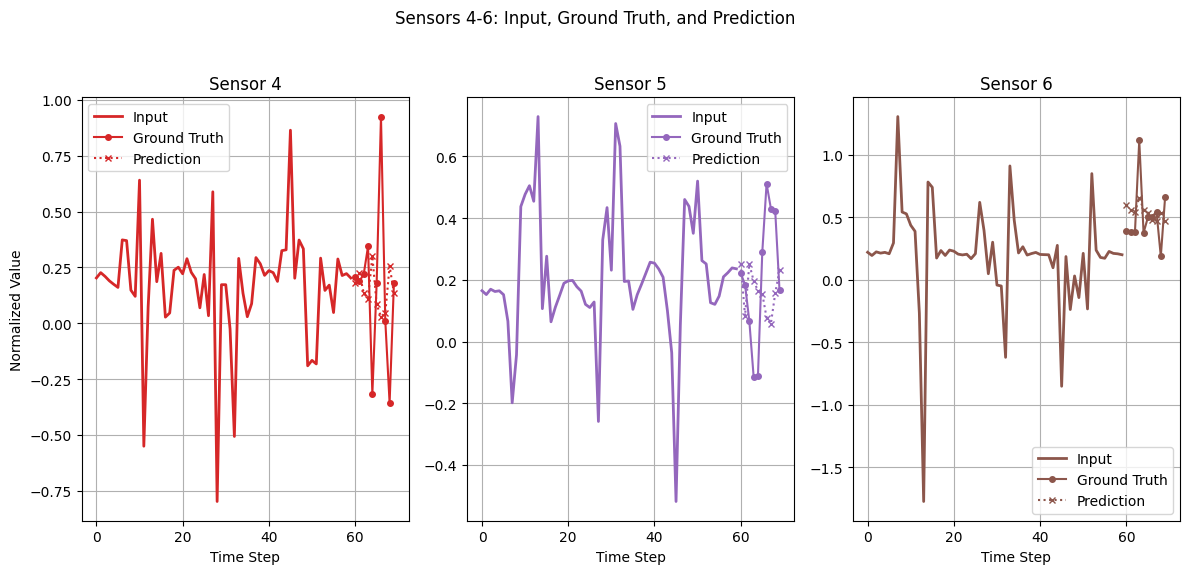

Visualizing sample index: 51


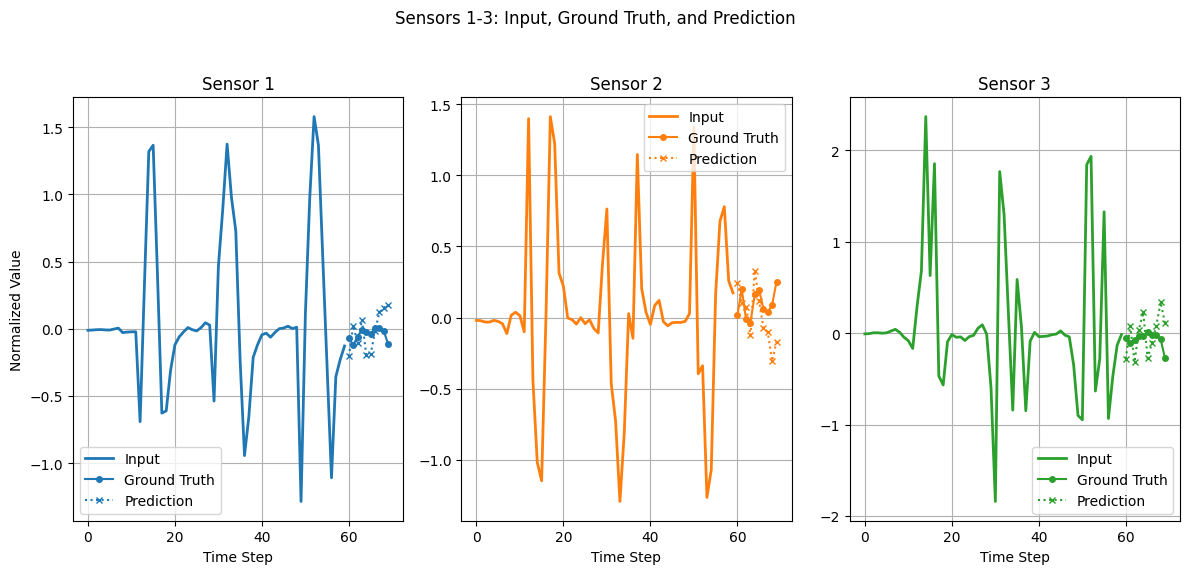

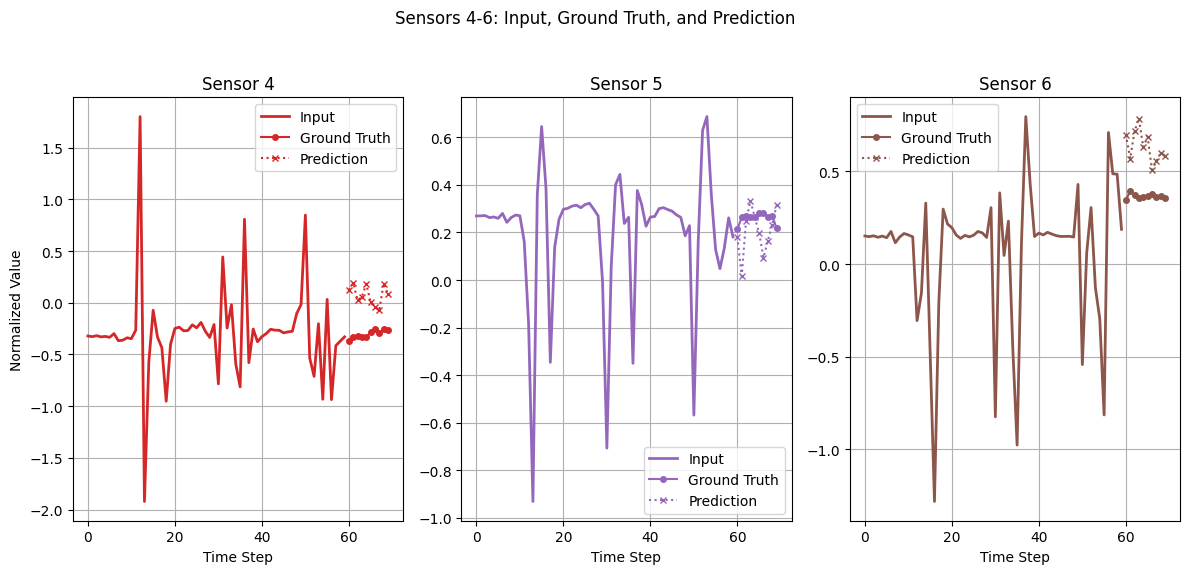

Visualizing sample index: 61


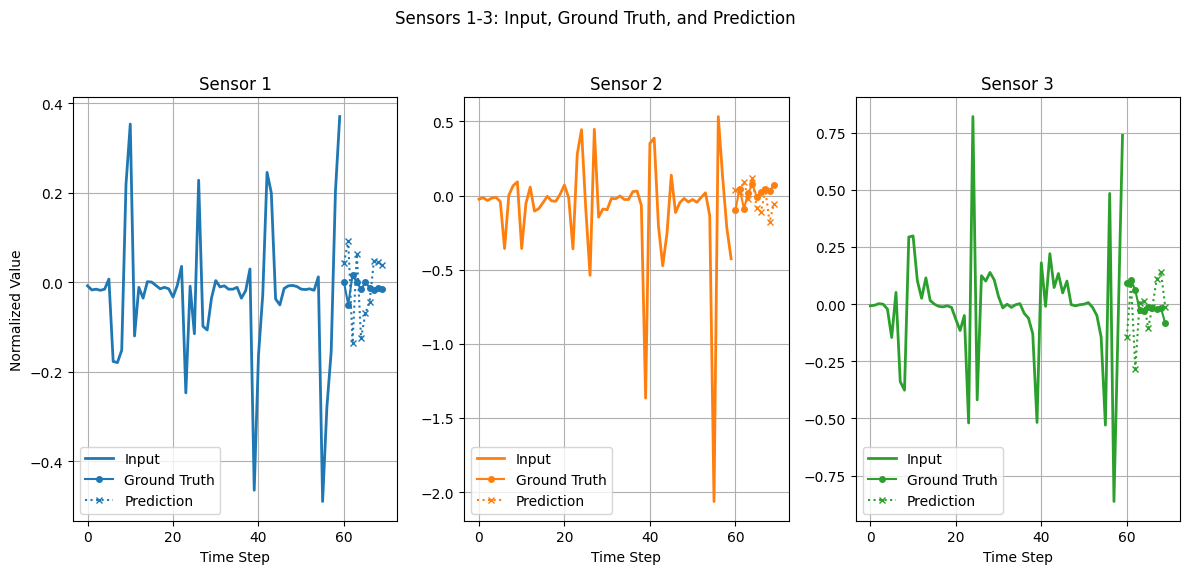

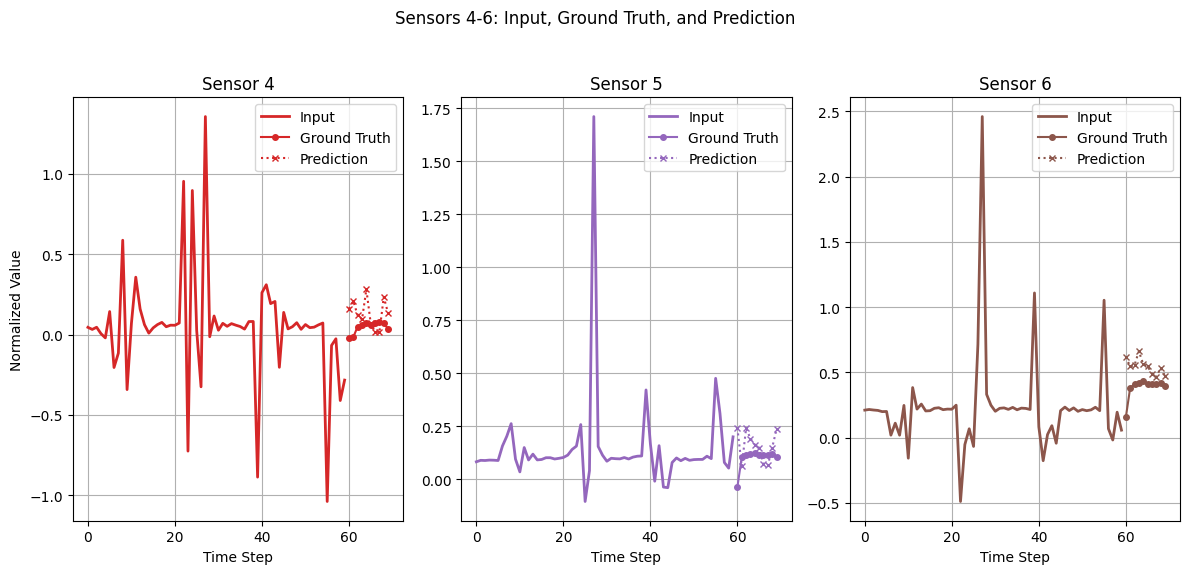

Visualizing sample index: 6


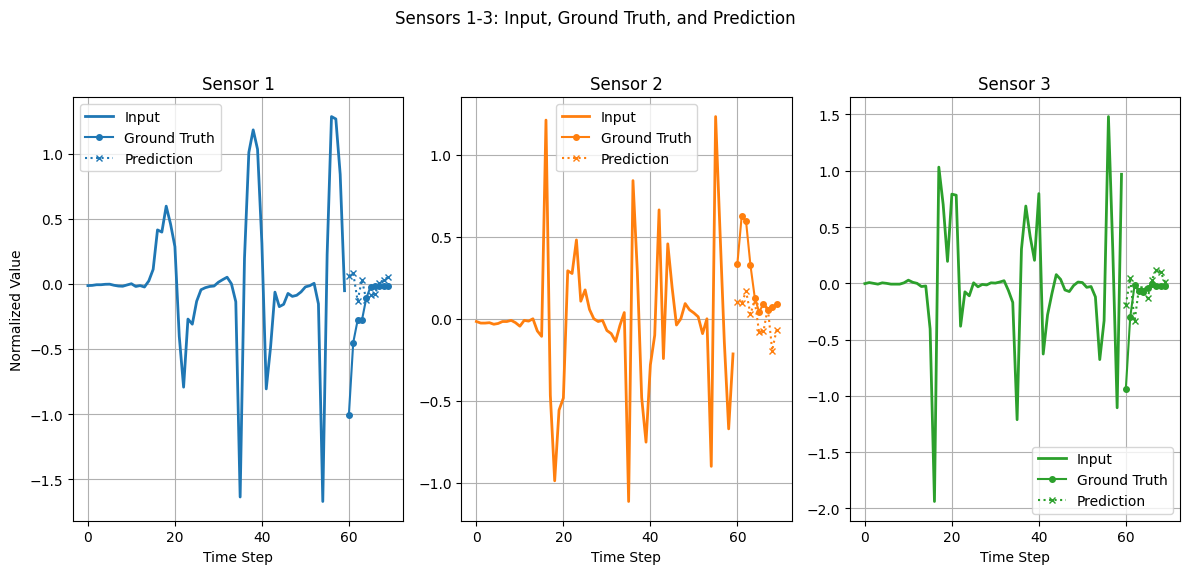

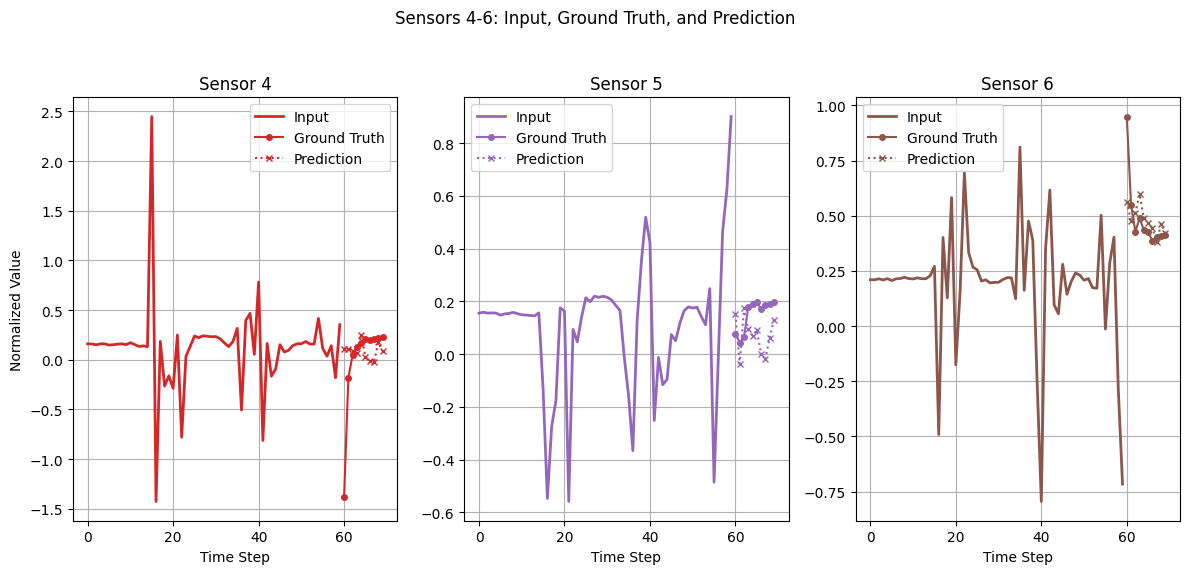

In [61]:
# -------------------------------
# RANDOMLY VISUALIZE MULTIPLE SAMPLES
# -------------------------------
# Define the number of random samples you wish to visualize
num_samples_to_visualize = 5

# Get random indices from the training dataset
total_samples = len(train_dataset)
random_indices = random.sample(range(total_samples), num_samples_to_visualize)

for idx in random_indices:
    print(f"Visualizing sample index: {idx}")
    sample = train_dataset[idx]
    visualize_sample(sample, model, config, device)


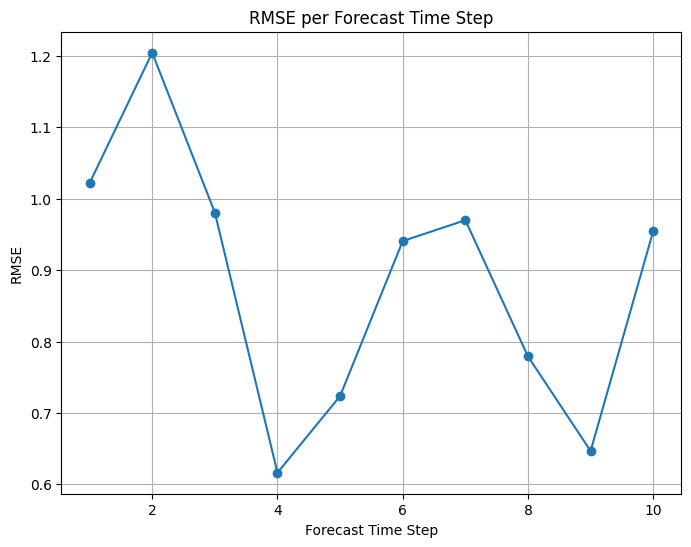

In [62]:
squared_errors = np.zeros(predict_size)  # to accumulate squared errors per time step
total_samples = 0

criterion = torch.nn.MSELoss(reduction='none')  # we'll average manually over channels

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        pred = model(batch_X)  # shape: (batch_size, predict_size, 6)
        # Compute squared error per sensor channel
        error = (pred - batch_y) ** 2  # shape: (batch_size, predict_size, 6)
        # Average error over sensor channels → (batch_size, predict_size)
        error = error.mean(dim=2)
        squared_errors += error.sum(dim=0).cpu().numpy()
        total_samples += error.size(0)

# Compute RMSE for each forecast time step
rmse_per_step = np.sqrt(squared_errors / total_samples)

# ===============================
# PLOTTING THE RMSE METRIC
# ===============================
time_steps = np.arange(1, predict_size + 1)  # Forecast steps 1 to predict_size
plt.figure(figsize=(8, 6))
plt.plot(time_steps, rmse_per_step, marker='o', linestyle='-')
plt.xlabel("Forecast Time Step")
plt.ylabel("RMSE")
plt.title("RMSE per Forecast Time Step")
plt.grid(True)
plt.show()